In [1]:
import sys
sys.path.append("../src/")
sys.path.append("../src/AtomicH")

In [2]:
import elastic
import potentials
import constants
import spinexchange
import dipolelosses
import numpy as np
import pylab as plt
from dipolelosses import DipoleChannels
from spinexchange import SpinExChannels

In [3]:
potT = potentials.Silvera_Triplet

B_values = np.logspace(-3, 1, 50)
T = 5e-4
rhos = np.linspace(1e-9, 0.75, 2000)

G_factors_rawDip = {}
G_factor_ratiosDip = {}

base_key = "Silvera"
base_potential = potentials.Triplets[base_key]


base_losses_by_channel = {}
for c in DipoleChannels:
    base_losses_by_channel[str(c)] = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, base_potential, rhos)for B in B_values])

for pot_key, pot in potentials.Triplets.items():
    G_factors_rawDip[pot_key] = {}
    G_factor_ratiosDip[pot_key] = {}

    for c in DipoleChannels:
        channel_str = str(c)
        losses = np.array([dipolelosses.GetGFactor(c, B, constants.TritiumConstants(), T, pot, rhos)for B in B_values])
        G_factors_rawDip[pot_key][channel_str] = losses
        G_factor_ratiosDip[pot_key][channel_str] = losses / base_losses_by_channel[channel_str]


/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)
/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)


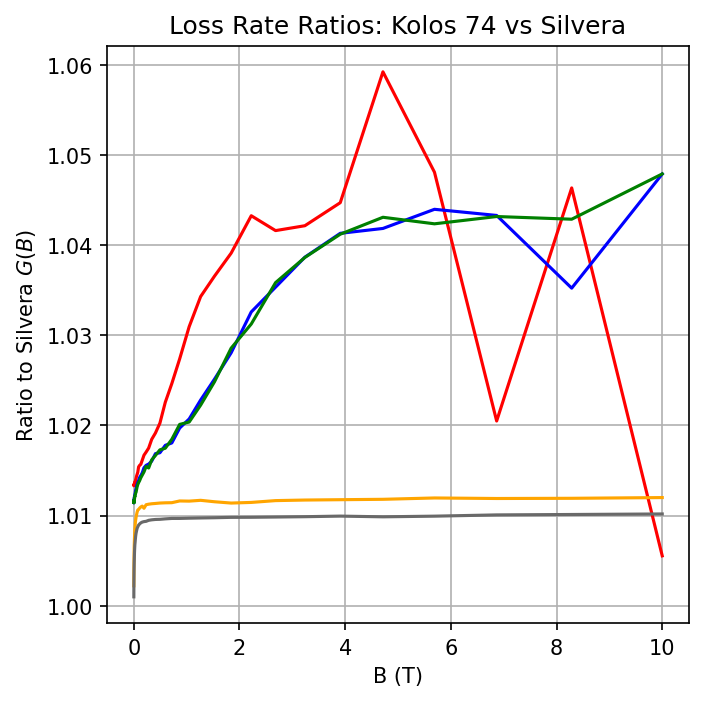

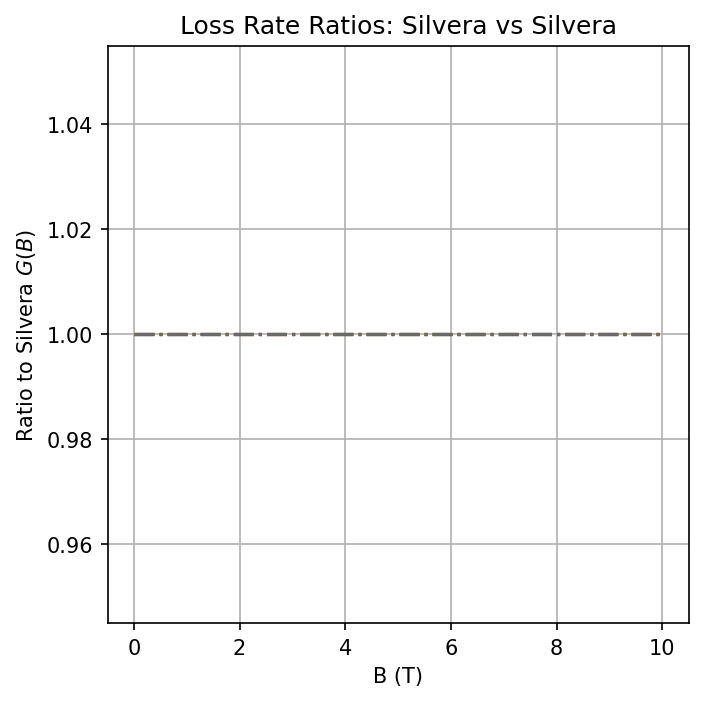

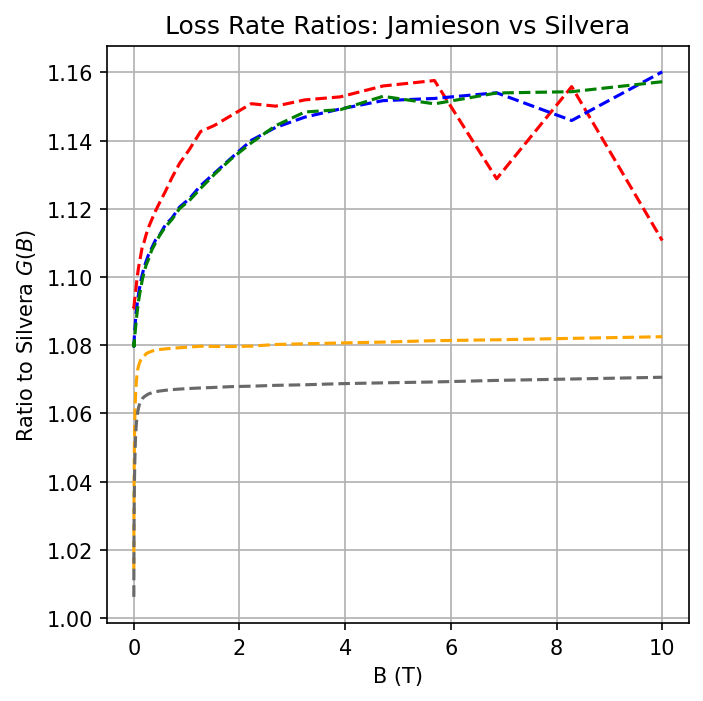

In [4]:
colors = ['red', 'blue', 'green', 'orange', 'dimgrey']
linetypes = ['-', '-.', '--', ':']

for pi, pot_key in enumerate(potentials.Triplets.keys()):
    plt.figure(figsize=(5, 5), dpi=150)

    for ci, c in enumerate(DipoleChannels):
        channel_str = str(c)
        try:
            ratios = G_factor_ratiosDip[pot_key][channel_str]
            label = f"Channel {ci+1}" if pi == 0 else None  
            plt.plot(B_values, ratios,
                     linetypes[pi % len(linetypes)],
                     color=colors[ci % len(colors)],
                     label=label)
        except KeyError:
            print(f"Missing: {pot_key} | {channel_str}")

    plt.xlabel("B (T)")
    plt.ylabel(f"Ratio to {base_key} $G(B)$")
    plt.title(f"Loss Rate Ratios: {pot_key} vs {base_key}")
    plt.grid(True, which='both')
    plt.show()


In [5]:
potS = potentials.Kolos_Singlet2_VDW

G_factors_raw_SETrip = {}
G_factor_ratios_SETrip = {}

base_key = "Silvera"
base_pot = potentials.Triplets[base_key]

for pot_key in potentials.Triplets.keys():
    potT = potentials.Triplets[pot_key]
    all_losses = []
    for c in SpinExChannels:
        losses = np.array([
            spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values
        ])
        all_losses.append(losses)
    
    G_factors_raw_SETrip[pot_key] = np.array(all_losses)  
    
base_losses = G_factors_raw_SETrip[base_key]
for pot_key in potentials.Triplets.keys():
    if pot_key == base_key:
        continue
    G_factor_ratios_SETrip[pot_key] = G_factors_raw_SETrip[pot_key] / base_losses

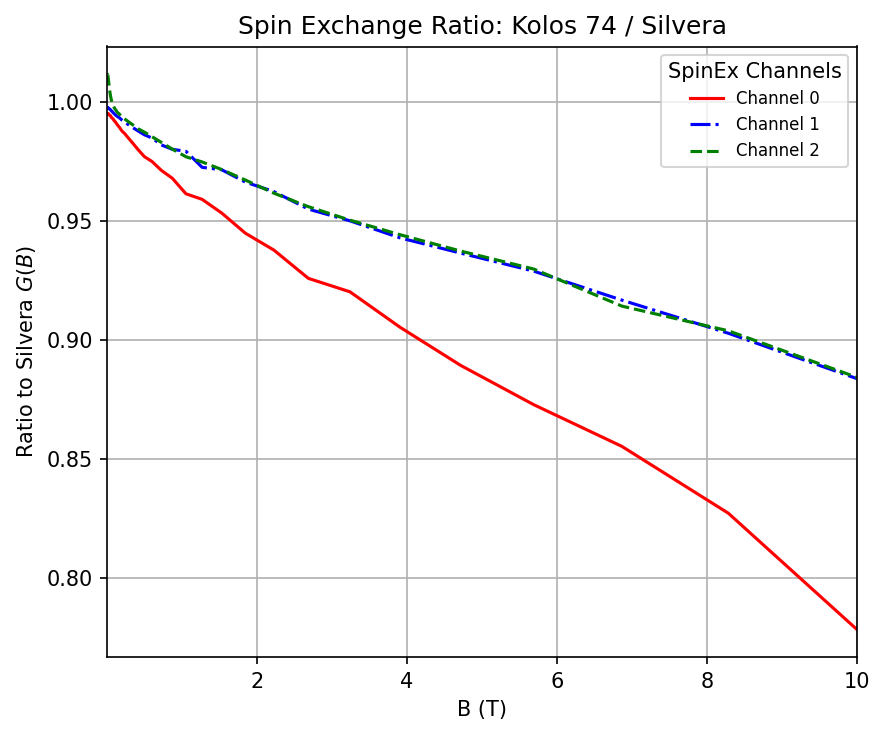

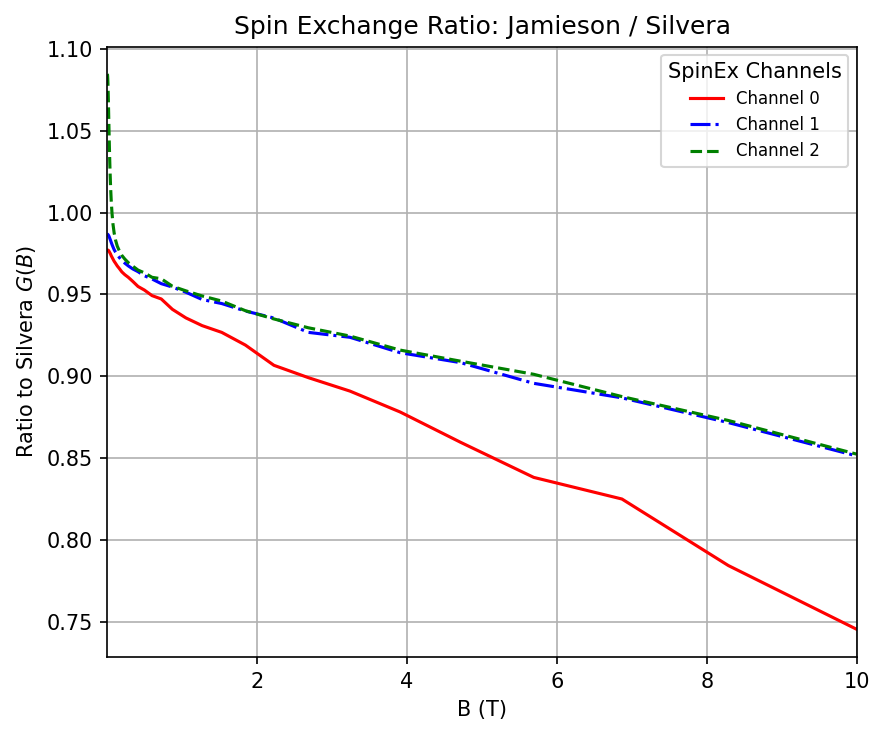

In [6]:
for pot_key in G_factor_ratios_SETrip:
    plt.figure(figsize=(6, 5), dpi=150)
    for ci, channel_ratios in enumerate(G_factor_ratios_SETrip[pot_key]):
        plt.plot(B_values, channel_ratios,
                 linestyle=linetypes[ci % len(linetypes)],
                 color=colors[ci % len(colors)],
                 label=f"Channel {ci}")
        
    plt.xlabel("B (T)")
    plt.xlim(0.001, 10)
    plt.ylabel(f'Ratio to {base_key} $G(B)$')
    plt.title(f"Spin Exchange Ratio: {pot_key} / {base_key}")
    plt.grid(True, which='both')
    plt.legend(title="SpinEx Channels", fontsize=8)
    plt.tight_layout()
    plt.show()

In [7]:
B_values = np.logspace(-3, 1, 50)
T = 1e-5
rhos = np.linspace(1e-9, 20 * constants.BohrInAng / constants.hcInEVAngstrom, 2000)
potT = potentials.Silvera_Triplet 

G_factors_raw_SESing = {}
G_factor_ratios_SESing = {}

base_key = list(potentials.Singlets.keys())[0]
base_pot = potentials.Singlets[base_key]

for pot_key, potS in potentials.Singlets.items():
    all_losses = []
    for c in SpinExChannels:
        losses = np.array([
            spinexchange.GetGFactor(c, B, constants.TritiumConstants(), T, potT, potS, rhos)
            for B in B_values
        ])
        all_losses.append(losses)
    
    G_factors_raw_SESing[pot_key] = np.array(all_losses)

base_losses = G_factors_raw_SESing[base_key]
for pot_key in potentials.Singlets.keys():
    if pot_key == base_key:
        continue
    G_factor_ratios_SESing[pot_key] = G_factors_raw_SESing[pot_key] / base_losses


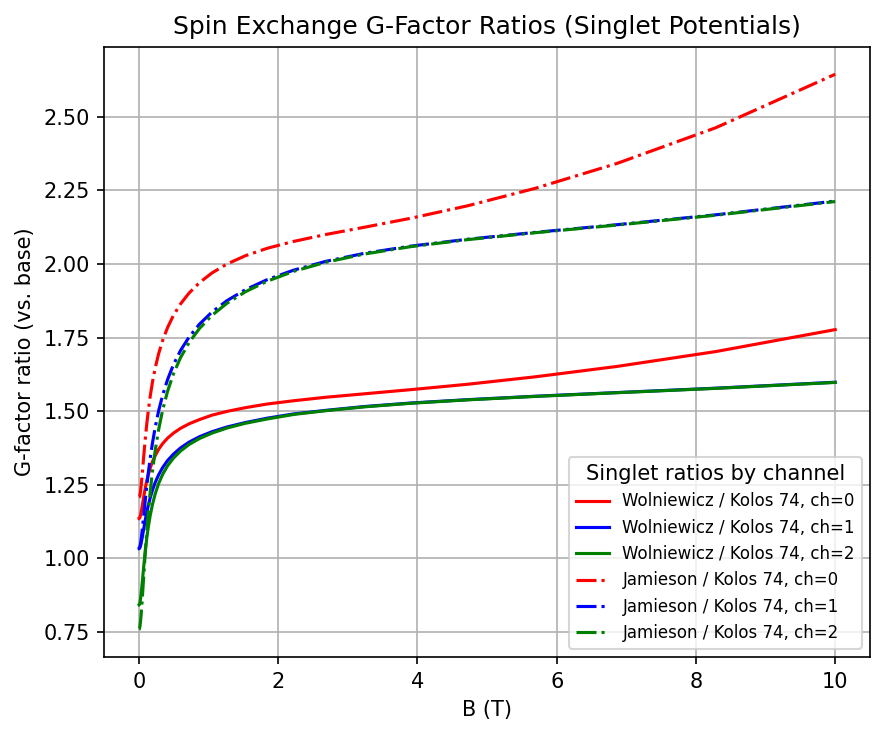

In [8]:
plt.figure(figsize=(6, 5), dpi=150)
pi = 0
for pot_key, ratio_array in G_factor_ratios_SESing.items():
    ci = 0
    for channel_index in range(len(SpinExChannels)):
        plt.plot(
            B_values,
            ratio_array[channel_index],
            linestyle=linetypes[pi % len(linetypes)],
            color=colors[ci % len(colors)],
            label=f"{pot_key} / {base_key}, ch={channel_index}"
        )
        ci += 1
    pi += 1

plt.xlabel("B (T)")
plt.ylabel("G-factor ratio (vs. base)")
plt.title("Spin Exchange G-Factor Ratios (Singlet Potentials)")
plt.grid(which='both')
plt.legend(loc='best', fontsize=8, title="Singlet ratios by channel")
plt.tight_layout()
plt.show()


In [9]:
def get_perturbed_results(attr_ref, delta):
    consts = constants.TritiumConstants()
    for name in dir(consts):
        if getattr(consts, name) is attr_ref:
            attr_name = name
            break

    setattr(consts, attr_name, attr_ref + delta)

    results = {}
    for c in DipoleChannels:
        Gs = []
        for B in B_values:
            Gs.append(dipolelosses.GetGFactor(c, B, consts, T, potentials.Silvera_Triplet, rhos, lin=0, lout=2))
        results[str(c)] = np.array(Gs)

    return results

attr_to_perturb = constants.TritiumConstants.nm
delta_value = constants.meeV 
G_perturbed = get_perturbed_results(attr_to_perturb, delta_value)

/Users/tikitorch/AtomicHScattering/examples/../src/AtomicH/dipolelosses.py:66: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Integral = quad(Integrand, rhos[0], rhos[-1])[0] / (P1 * P2)


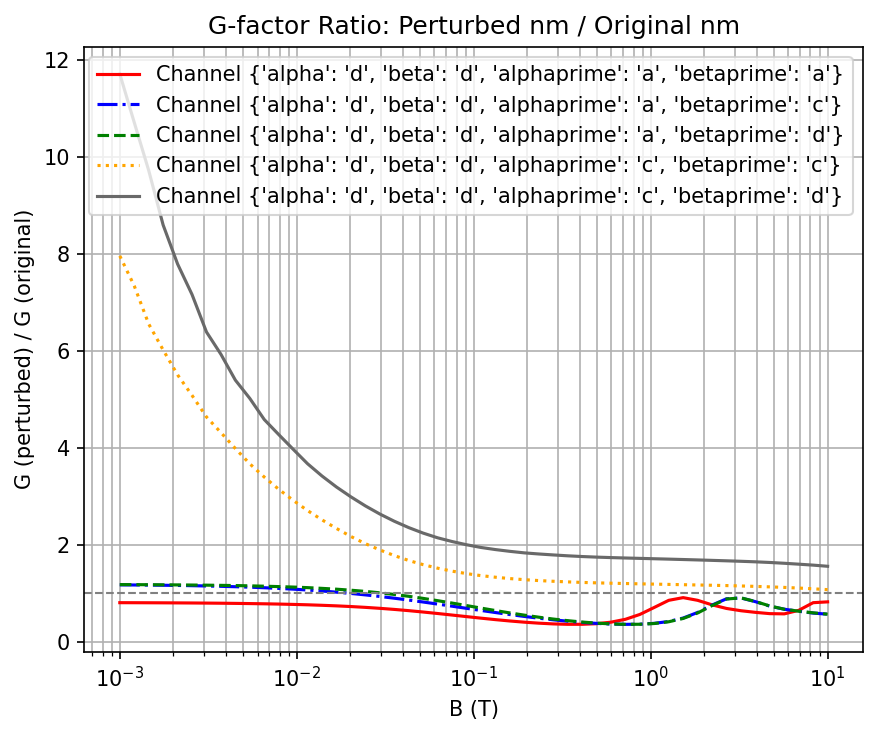

In [10]:
original = G_factors_rawDip["Silvera"]  
ratio_vs_unperturbed = {}

for channel_str in original.keys():
    unperturbed = original[channel_str]
    perturbed = G_perturbed[channel_str]
    ratio_vs_unperturbed[channel_str] = perturbed / unperturbed

plt.figure(figsize=(6, 5), dpi=150)

for i, (channel_str, ratio) in enumerate(ratio_vs_unperturbed.items()):
    plt.plot(B_values, ratio,
             label=f"Channel {channel_str}",
             linestyle=linetypes[i % len(linetypes)],
             color=colors[i % len(colors)])

plt.xscale("log")
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.xlabel("B (T)")
plt.ylabel("G (perturbed) / G (original)")
plt.title("G-factor Ratio: Perturbed nm / Original nm")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()
